In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# ================================
# Point-Zero Rebuild: Data Loading & Clean Feature Matrix (Week 2 reset, improved)
# ================================
import pandas as pd, numpy as np, re
from collections import Counter

# ---- Helper: small pretty list
def headlist(x, k=12): 
    return list(x)[:k] + (["..."] if len(x) > k else [])

# ---- 0) Load & normalize column names
Merged = pd.read_csv("merged_full.csv", low_memory=False)
Merged.columns = [str(c).strip().lower() for c in Merged.columns]

print(f"[load] rows={len(Merged):,}, cols={len(Merged.columns)}")
print("[load] sample columns:", headlist(Merged.columns))

# ---- 1) Restrict to endline/follow-up if present
endline_filters = [
    ("followup", lambda s: s == 1),
    ("endline",  lambda s: s == 1),
    ("post",     lambda s: s == 1),
    ("wave",     lambda s: s.astype(str).str.lower().isin(["1","end","endline","post"])),
]
AppliedFilter = None
for col, cond in endline_filters:
    if col in Merged.columns:
        try:
            mask = cond(Merged[col])
            if mask.sum() > 0 and mask.sum() < len(Merged):
                Merged = Merged.loc[mask].copy()
                AppliedFilter = col
                print(f"[restrict] kept endline via '{col}': n={len(Merged):,}")
                break
        except Exception:
            pass
if AppliedFilter is None:
    print("[restrict] no explicit endline/follow-up flag found or usable; using full sample.")

# ---- 2) Choose outcome Y and baseline outcome Y0 (robust patterns)
def pick_first_exist(candidates, where, label):
    for c in candidates:
        if c in where:
            print(f"[choose] {label}: '{c}'")
            return c
    raise KeyError(f"No candidate found for {label}. Tried: {candidates}")

Y_candidates  = ["totalc", "consumption1", "totalc_end", "totalc1", "cons_total1", "consumption_end"]
Y0_candidates = ["totalc0", "consumption0", "totalc_base", "cons_total0", "consumption_baseline"]

Y_col  = pick_first_exist(Y_candidates,  Merged.columns, "endline outcome Y")
Y0_col = pick_first_exist(Y0_candidates, Merged.columns, "baseline outcome Y0")

Y_series  = pd.to_numeric(Merged[Y_col],  errors="coerce")
baselineY = pd.to_numeric(Merged[Y0_col], errors="coerce")

# ---- Optional: log-transform outcome and its baseline counterpart
USE_LOG = True  # flip to False if you want to go back to levels
if USE_LOG:
    Y_series  = np.log1p(Y_series.astype(float))
    baselineY = np.log1p(baselineY.astype(float))
    print(f"[transform] Applied log1p to outcome '{Y_col}' and baseline '{Y0_col}'")
else:
    print(f"[transform] Keeping outcome '{Y_col}' and baseline '{Y0_col}' in levels")

# ---- 3) Treatment (village-level assignments with 0/1/2)
treat_candidates = ["treatment.x", "treated", "treatment", "treat", "assign", "assign_treat", "village_treat"]
treat_col = pick_first_exist(treat_candidates, Merged.columns, "treatment indicator")

treat_raw = pd.to_numeric(Merged[treat_col], errors="coerce")
treat_any   = (treat_raw > 0).astype("Int64")         # pooled ITT
treat_indiv = (treat_raw == 1).astype("Int64")
treat_group = (treat_raw == 2).astype("Int64")

# Diagnostics
vc = treat_raw.value_counts(dropna=False).sort_index()
print(f"[treat] column='{treat_col}', counts:\n{vc.to_string()}")
print(f"[treat] share any={float(treat_any.mean(skipna=True)):.3f}, "
      f"indiv={float(treat_indiv.mean(skipna=True)):.3f}, group={float(treat_group.mean(skipna=True)):.3f}")

# ---- 4) Candidate baseline features (improved rules)
def is_baseline_col(c):
    return bool(re.search(r"(?:^.*0$|_0$|base|baseline|^pre_)", c))

cols = set(Merged.columns)
paired_y = {c for c in cols if c.endswith(".y") and c[:-2]+".x" in cols}
baseline_like = [c for c in cols if (is_baseline_col(c) or c.endswith(".x")) and c not in paired_y]

ALWAYS_KEEP = [
    "male", "female", "age", "age.x", "age_head", "age_head0",
    "rship", "relation", "relation_to_head", "rship.x",
    "aimag", "aimag.x", "soum", "soum.x", "region", "region0", "province", "province0",
    "urban", "urban0",
    "hhsize", "hhsize0", "children", "children0", "dependents", "dependents0",
    "educ_head", "educ_head0", "married", "married0",
]
EXCLUDE_IDS = [
    "case_id", "hhid", "household_id", "person_id", "cluster_id", "village_id",
    "rescode", "rescode.x", "rescode.y", "ind", "indid", "enumerator", "survey_id"
]
EXCLUDE_EXPLICIT = {Y_col, Y0_col, treat_col, "baselineY"}

baseline_candidates = sorted(set(baseline_like + [c for c in ALWAYS_KEEP if c in cols])
                             - set(EXCLUDE_IDS) - EXCLUDE_EXPLICIT)

print(f"[features] baseline-like by pattern/.x: {len(baseline_like)}; +always-keep; -ids → {len(baseline_candidates)}")
print("[features] sample baseline candidates:", headlist(baseline_candidates, 20))

# ---- 5) Assemble X_full (baseline-only set) + add treatment and baselineY
X_full = Merged[baseline_candidates].copy()

# Identify numeric vs categorical BEFORE coercion (diagnostics)
types_before = {c: str(Merged[c].dtype) for c in X_full.columns}
num_like_cols = [c for c in X_full.columns if pd.api.types.is_numeric_dtype(Merged[c])]
obj_like_cols = [c for c in X_full.columns if not pd.api.types.is_numeric_dtype(Merged[c])]
print(f"[types] numeric-like={len(num_like_cols)}, non-numeric-like={len(obj_like_cols)}")

# Coerce numerics; keep categoricals as strings for one-hot later
for c in num_like_cols:
    X_full[c] = pd.to_numeric(X_full[c], errors="coerce")
for c in obj_like_cols:
    X_full[c] = Merged[c].astype("string")

# Explicit treatment controls (numeric) + baseline outcome
X_full["treat_any"]   = treat_any.astype("float")
X_full["treat_indiv"] = treat_indiv.astype("float")
X_full["treat_group"] = treat_group.astype("float")
X_full["baselineY"]   = baselineY

# ---- 6) Row filter: require Y, baselineY, and non-missing raw treatment
keep_rows = (
    Y_series.notna() &
    X_full["baselineY"].notna() &
    treat_raw.notna()
)
n_before = len(X_full)
X_full = X_full.loc[keep_rows].copy()
Y_use  = Y_series.loc[keep_rows].copy()
print(f"[rows] kept rows with non-missing Y / baselineY / treatment: {len(X_full):,} (dropped {n_before - len(X_full):,})")

# ---- 7) Drop columns with extreme missingness (>95% NaN)
missing_rate = X_full.isna().mean().sort_values(ascending=False)
PROTECT = {"treat_any","treat_indiv","treat_group","baselineY"}
too_missing = [c for c in missing_rate.index if missing_rate[c] > 0.95 and c not in PROTECT]
if too_missing:
    print(f"[drop] >95% missing: dropping {len(too_missing)} cols")
    X_full = X_full.drop(columns=too_missing)

# ---- 8) Impute numeric mean; categorical mode (unchanged)
num_cols = [c for c in X_full.columns if pd.api.types.is_numeric_dtype(X_full[c])]
cat_cols = [c for c in X_full.columns if c not in num_cols]

if num_cols:
    X_full[num_cols] = X_full[num_cols].apply(lambda col: col.fillna(col.mean()))
if cat_cols:
    for c in cat_cols:
        mode = X_full[c].mode(dropna=True)
        fill = mode.iloc[0] if not mode.empty else "missing"
        X_full[c] = X_full[c].fillna(fill)

# ---- 8.5) Log-transform eligible numeric X-features (safe log1p)
LOG_PROTECT = {"treat_any", "treat_indiv", "treat_group", "baselineY"}  # never log these

def looks_logged(name: str) -> bool:
    return bool(re.search(r"(?:^log[_]?|[_](log|ln)$|[_]log[_]?|[_]ln$|^ln[_]?)", name))

def is_indicator_like(s: pd.Series) -> bool:
    return s.nunique(dropna=True) <= 10 and set(s.dropna().unique()).issubset({0, 1, 2, 3})

def log_candidate(col: str, s: pd.Series) -> bool:
    if col in LOG_PROTECT: return False
    if looks_logged(col):  return False
    if is_indicator_like(s): return False
    if s.min() < 0:        return False
    if s.quantile(0.95) <= 1.0: return False
    if s.nunique(dropna=True) < 20: return False
    return True

log_applied = []
for c in [c for c in X_full.columns if pd.api.types.is_numeric_dtype(X_full[c])]:
    s = X_full[c]
    if log_candidate(c, s):
        X_full[c] = np.log1p(s.astype(float))
        log_applied.append(c)

print(f"[logX] Applied log1p to {len(log_applied)} numeric features.")
if log_applied:
    print("         e.g.,", headlist(sorted(log_applied), 12))

# ---- 9) One-hot encode categoricals, then drop zero-variance columns
X_cat = pd.get_dummies(X_full[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=X_full.index)
X_num = X_full[num_cols] if num_cols else pd.DataFrame(index=X_full.index)

# Ensure protected numerics are present
for k in ["treat_any","treat_indiv","treat_group","baselineY"]:
    if k not in X_num.columns and k in X_full.columns:
        X_num[k] = X_full[k]

X_proc = pd.concat([X_num, X_cat], axis=1)

# Zero variance after impute/encode
nuniq = X_proc.nunique(dropna=True)
zerovar = [c for c in nuniq[nuniq <= 1].index if c not in PROTECT]
if zerovar:
    print(f"[drop] zero-variance columns: {len(zerovar)}")
    X_proc = X_proc.drop(columns=zerovar)

# ---- 9.5) Drop high-cardinality categorical dummies (do this BEFORE scaling)  [FIX]
K = 100
if not X_cat.empty:
    # Map dummy back to its source categorical for counting
    orig_cat = X_cat.columns.to_series().str.extract(r"^(.*?)[_=].*$", expand=False)
    dummy_counts = orig_cat.value_counts()
    id_like_cats = dummy_counts[dummy_counts > K].index.tolist()
    if id_like_cats:
        drop_cols = [c for c in X_proc.columns if any(c.startswith(name + "_") or c.startswith(name + "=") for name in id_like_cats)]
        drop_cols = [c for c in drop_cols if c not in PROTECT]
        if drop_cols:
            print(f"[drop] high-cardinality categorical (>{K} dummies): {id_like_cats} → dropping {len(drop_cols)} cols")
            X_proc = X_proc.drop(columns=drop_cols, errors="ignore")

# ---- 9.75) Coerce boolean columns to 0/1 BEFORE scaling  [FIX]
bool_cols_proc = [c for c in X_proc.columns if X_proc[c].dtype == "bool"]
if bool_cols_proc:
    print(f"[cast] converting {len(bool_cols_proc)} boolean cols to int 0/1")
    X_proc[bool_cols_proc] = X_proc[bool_cols_proc].astype("int8")
            
            
print(f"[shape] X_proc pre-scale: n={X_proc.shape[0]:,}, p={X_proc.shape[1]:,}")


# ---- 10) Min–Max scale to [0,1] (after all drops)
def minmax_01(col: pd.Series) -> pd.Series:
    col = col.astype("float64")  # ensure arithmetic-safe
    cmin, cmax = col.min(), col.max()
    if pd.isna(cmin) or pd.isna(cmax) or cmax == cmin:
        return pd.Series(0.0, index=col.index)  # constant/all-NaN → 0
    return (col - cmin) / (cmax - cmin)




# Scale ONLY numeric columns (dummies are numeric but remain 0/1 under min–max)
num_cols_proc = [c for c in X_proc.columns if pd.api.types.is_numeric_dtype(X_proc[c])]
X_scaled = X_proc.copy()
if num_cols_proc:
    X_scaled[num_cols_proc] = X_scaled[num_cols_proc].apply(minmax_01)
print(f"[scale] min–max scaled {len(num_cols_proc)} numeric features to [0,1].")



# ---- 10.6) Sanity checks: verify all numeric features are in [0,1]
import numpy as np
import pandas as pd

def check_unit_interval(df: pd.DataFrame, eps: float = 1e-9):
    num = df.select_dtypes(include=[np.number])
    if num.empty:
        print("[check] no numeric columns to verify.")
        return

    report = pd.DataFrame({
        "min": num.min(axis=0),
        "max": num.max(axis=0),
        "n_lt0": (num < -eps).sum(axis=0),
        "n_gt1": (num > 1.0 + eps).sum(axis=0),
        "n_nan": num.isna().sum(axis=0),
        "n_inf": np.isinf(num).sum(axis=0).astype(int),
    })

    offenders = report.query("n_lt0 > 0 or n_gt1 > 0 or n_nan > 0 or n_inf > 0")
    print(f"[check] numeric columns: {num.shape[1]}")
    if offenders.empty:
        print(f"[check] ✅ all numeric columns are within [0,1] (tol={eps}), finite, and non-missing.")
    else:
        print(f"[check] ⚠️ {len(offenders)} column(s) outside [0,1] / non-finite / NaN. Top offenders:")
        # show up to 20 worst offenders, sorted by counts above bounds
        display_cols = offenders.sort_values(["n_lt0","n_gt1","n_nan","n_inf"], ascending=False).head(20)
        print(display_cols.to_string())

    # hard assert (will raise if any violation)
    assert (report["min"] >= -eps).all() and (report["max"] <= 1.0 + eps).all() \
        and (report["n_nan"] == 0).all() and (report["n_inf"] == 0).all(), \
        "Some numeric columns violate [0,1] bounds or contain NaN/Inf."

# call the checker
check_unit_interval(X_scaled, eps=1e-9)



# ---- 11) Build final dataset for modeling (use scaled features)
Data_all = pd.concat([Y_use.rename(Y_col), X_scaled], axis=1)
Y = Data_all[Y_col].to_numpy()
X = Data_all.drop(columns=[Y_col])

print("Data shape (n, p):", X.shape[0], X.shape[1])
print("First few columns:", headlist(X.columns, 20))
print("Confirm treatment columns present:",
      all(k in X.columns for k in ["treat_any","treat_indiv","treat_group"]))


[load] rows=2,109, cols=2416
[load] sample columns: ['case_id', 'hhid', 'rescode.x', 'ind', 'aimag.x', 'soum.x', 'treatment.x', 'followup', 'xxxxxbasichhcharacteristicsxxxxx', 'male', 'rship', 'age.x', '...']
[restrict] kept endline via 'followup': n=961
[choose] endline outcome Y: 'totalc'
[choose] baseline outcome Y0: 'totalc0'
[transform] Applied log1p to outcome 'totalc' and baseline 'totalc0'
[choose] treatment indicator: 'treatment.x'
[treat] column='treatment.x', counts:
treatment.x
0    260
1    350
2    351
[treat] share any=0.729, indiv=0.364, group=0.365
[features] baseline-like by pattern/.x: 896; +always-keep; -ids → 896
[features] sample baseline candidates: ['age.x', 'aimag.x', 'alcohol1.x', 'alcohol10', 'alcohol2.x', 'alcohol20', 'alcohol2_m0', 'alcohol3.x', 'alcohol30', 'alcohol3_m0', 'alcohol4.x', 'alcohol40', 'alcohol4_m0', 'alcohol5.x', 'alcohol50', 'alcohol6.x', 'alcohol60', 'alcohol_c0', 'alcohol_ck10', 'alcohol_ck20', '...']
[types] numeric-like=877, non-numeric-

/tmp/ipykernel_1013/1728414344.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_full["treat_any"]   = treat_any.astype("float")
/tmp/ipykernel_1013/1728414344.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_full["treat_indiv"] = treat_indiv.astype("float")
/tmp/ipykernel_1013/1728414344.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

[logX] Applied log1p to 308 numeric features.
         e.g., ['age.x', 'alcohol4.x', 'alcohol40', 'alcohol4_m0', 'alcohol_c0', 'alcohol_cm0', 'alcohol_pp0', 'alcohol_ps0', 'animals0', 'assets_all0', 'bod0', 'books12.x', '...']
[drop] zero-variance columns: 51
[drop] high-cardinality categorical (>100 dummies): ['inigiv', 'inirec'] → dropping 256 cols
[shape] X_proc pre-scale: n=961, p=719
[scale] min–max scaled 719 numeric features to [0,1].
[check] numeric columns: 719
[check] ✅ all numeric columns are within [0,1] (tol=1e-09), finite, and non-missing.
Data shape (n, p): 961 719
First few columns: ['age.x', 'aimag.x', 'alcohol1.x', 'alcohol10', 'alcohol2.x', 'alcohol20', 'alcohol2_m0', 'alcohol3.x', 'alcohol30', 'alcohol3_m0', 'alcohol4.x', 'alcohol40', 'alcohol4_m0', 'alcohol5.x', 'alcohol50', 'alcohol_c0', 'alcohol_ck10', 'alcohol_ck20', 'alcohol_ckm0', 'alcohol_cm0', '...']
Confirm treatment columns present: True


# Ridge

In [4]:
# Hook Into the cleaned data
# Expect these to exist from your cleaning step:
#   - Y_col (str)       : chosen outcome column name
#   - Y_use (Series)    : final outcome (possibly log1p)
#   - X_proc (DataFrame): numeric + one-hot cats (pre-standardization, protected vars intact)
#   - X_scaled (DataFrame): standardized version (z-score), not used in pipeline CV to avoid double scaling

assert 'Y_use' in globals(), "Run the cleaning code first so Y_use, X_proc, Y_col exist."
assert 'X_proc' in globals(), "Run the cleaning code first so X_proc exists."
assert 'Y_col' in globals(), "Run the cleaning code first so Y_col exists."

# Cell 1 — replace with:
X_df = X_proc.copy()                         # keep names here
feature_names = X_df.columns.tolist()        # grab names once
X = X_df.values.astype(float)                # numpy for sklearn
Y = Y_use.values.astype(float)


feature_names = X_proc.columns.tolist()
print("Shapes — X:", X.shape, "Y:", Y.shape, "| Outcome:", Y_col)




Shapes — X: (961, 719) Y: (961,) | Outcome: totalc


In [5]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

# λ grid (called "alphas" in sklearn); span wide, scaled by sd(Y)
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
print("lambda grid (min, median, max):", float(lambdas.min()), float(np.median(lambdas)), float(lambdas.max()))


lambda grid (min, median, max): 0.01580660065737152 1591.3604376454646 158066006.57371518


In [6]:
# Ridge: path

# Manual standardization for the PATH computation only (to match the doc)
# Ensure NumPy array, then standardize with NumPy (supports keepdims)
X_arr = np.asarray(X, dtype=float)

Xc  = X_arr - np.mean(X_arr, axis=0, keepdims=True)
Xsd = np.std(X_arr, axis=0, ddof=0, keepdims=True)
Xsd[Xsd == 0] = 1.0  # guard zero-variance

Xs = Xc / Xsd


soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0.0, alphas=lambdas)[1]  # coef matrix p x len(lambdas)
soln_path = pd.DataFrame(soln_array.T, columns=feature_names, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path.head()


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75370.09726292772, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75370.09699004577, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75370.0969157262, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75370.08990945453, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75370.08798129503, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinat

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75369.90667734829, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75369.85694344601, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinat

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75365.46721670187, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75364.35264437614, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinat

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75317.31867770375, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75310.98263802519, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinat

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75228.1521199061, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75223.84639780087, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75198.01588240883, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75197.34669100185, tolerance: 15.074019454772964
  model = cd_fast.enet_coordinate_descent_gram(


,age.x,aimag.x,alcohol1.x,alcohol10,alcohol2.x,alcohol20,alcohol2_m0,alcohol3.x,alcohol30,alcohol3_m0,...,treat_indiv,treat_group,baselineY,otherb.x_garage,otherb.x_grocery shop,otherb.x_outhouse,otherb.x_rent house,otherb.x_rent house of cafe,otherb.x_shop house,otherb.x_winter fence of livestock
negative log(lambda),,,,,,,,,,,,,,,,,,,,,
-18.878523,2.855189e-10,-4.667070e-10,8.195693e-10,6.824631e-10,2.183233e-10,6.599515e-10,6.599515e-10,3.077767e-10,6.834243e-10,6.834243e-10,...,-1.961019e-10,3.478162e-10,1.816835e-09,1.667969e-10,7.560599e-11,-1.508492e-10,7.640349e-11,1.657142e-10,-1.041903e-10,1.089524e-10
-18.645939,3.602840e-10,-5.889174e-10,1.034179e-09,8.611707e-10,2.754928e-10,8.327643e-10,8.327643e-10,3.883702e-10,8.623836e-10,8.623836e-10,...,-2.474525e-10,4.388943e-10,2.292585e-09,2.104738e-10,9.540394e-11,-1.903501e-10,9.641027e-11,2.091076e-10,-1.314732e-10,1.374823e-10
-18.413355,4.546268e-10,-7.431294e-10,1.304986e-09,1.086674e-09,3.476325e-10,1.050829e-09,1.050829e-09,4.900675e-10,1.088205e-09,1.088205e-09,...,-3.122497e-10,5.538217e-10,2.892914e-09,2.655878e-10,1.203861e-10,-2.401946e-10,1.216560e-10,2.638639e-10,-1.659004e-10,1.734830e-10
-18.180770,5.736739e-10,-9.377229e-10,1.646705e-09,1.371227e-09,4.386625e-10,1.325996e-09,1.325996e-09,6.183951e-10,1.373158e-09,1.373158e-09,...,-3.940144e-10,6.988438e-10,3.650443e-09,3.351337e-10,1.519100e-10,-3.030912e-10,1.535124e-10,3.329585e-10,-2.093426e-10,2.189107e-10
-17.948186,7.238943e-10,-1.183272e-09,2.077907e-09,1.730292e-09,5.535292e-10,1.673217e-09,1.673217e-09,7.803261e-10,1.732729e-09,1.732729e-09,...,-4.971898e-10,8.818408e-10,4.606337e-09,4.228908e-10,1.916887e-10,-3.824578e-10,1.937107e-10,4.201459e-10,-2.641603e-10,2.762340e-10


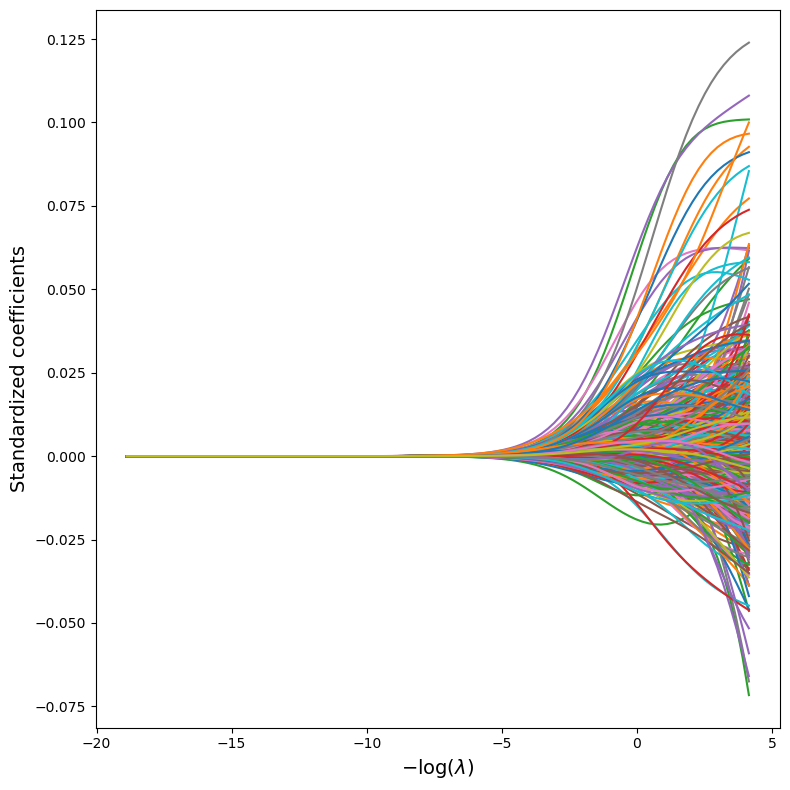

In [7]:
# Ridge: path plot

path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=14)
ax.set_ylabel('Standardized coefficients', fontsize=14);
path_fig.tight_layout()


In [8]:
# Ridge: CV (via Pipeline + GridSearchCV (MSE))

scaler = StandardScaler(with_mean=True, with_std=True)
ridge = skl.ElasticNet(l1_ratio=0)

pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

best_alpha_ridge = grid.best_params_['ridge__alpha']
print("Ridge — best lambda (alpha):", best_alpha_ridge)
print("Ridge — cv MSE at best:", -grid.best_score_)


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e+02, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+02, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+02, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+02, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+02, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e+02, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e+02, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+02, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+02, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+02, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+02, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e+02, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e+02, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+02, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e+02, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e+02, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e+02, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e+02, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e+02, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e+02, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e+02, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+02, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e+02, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+02, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+02, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+02, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.232e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+02, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+02, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.376e+01, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.819e+01, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.044e+01, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.921e+01, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.315e+01, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.621e+01, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.277e+01, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.154e+01, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+01, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+01, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.385e+01, tolerance: 3.033e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.499e+01, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e+01, tolerance: 3.206e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e+01, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+01, tolerance: 3.065e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e+01, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e+01, tolerance: 3.038e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e+01, tolerance: 3.042e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Ridge — best lambda (alpha): 3.3271379234347753
Ridge — cv MSE at best: 0.23682488678001076


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.870e+01, tolerance: 3.846e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


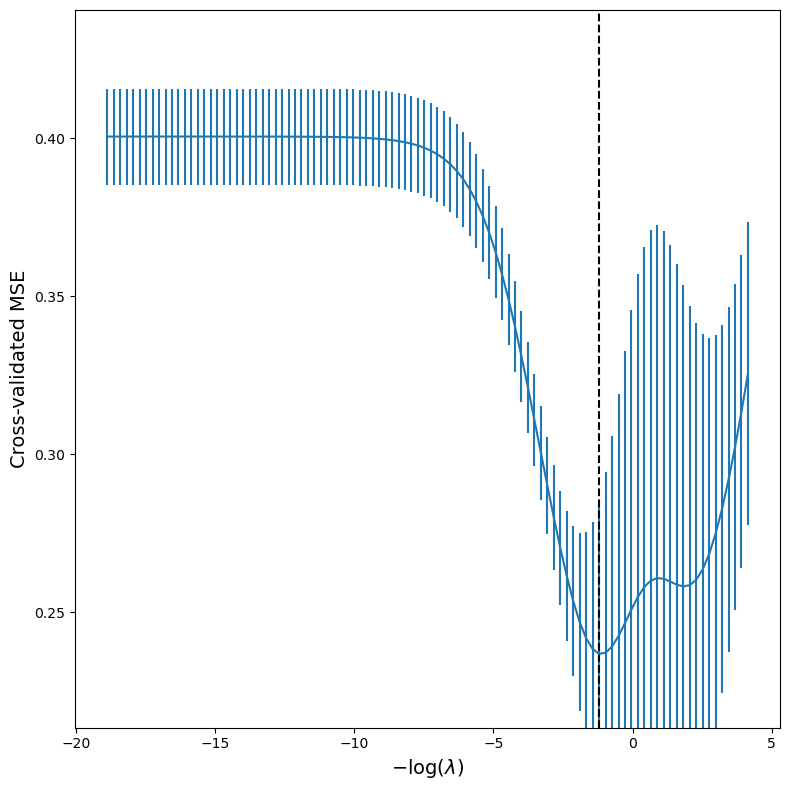

In [9]:
# Ridge: CV MSE Curve

ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.axvline(-np.log(best_alpha_ridge), c='k', ls='--')
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=14)
ax.set_ylabel('Cross-validated MSE', fontsize=14)
ax.set_ylim([np.percentile(-grid.cv_results_['mean_test_score'], 1)*0.9,
             np.percentile(-grid.cv_results_['mean_test_score'], 99)*1.1])
ridge_fig.tight_layout()


In [10]:
# Ridge: Coefficients at Tuned Lambda

tuned_ridge = grid.best_estimator_  # pipeline
# Extract coefficients on standardized scale stored in inner estimator:
coef_std = tuned_ridge.named_steps['ridge'].coef_
# Recover names
ridge_coefs = pd.Series(coef_std, index=feature_names).sort_values(key=np.abs, ascending=False)
ridge_coefs.head(20)


redmeat2.x    0.036283
butter_ps0    0.031132
cladul12.x    0.028658
transer7.x    0.024314
flour2.x      0.024241
schoo12.x     0.020654
milk2.x       0.020642
vehicl11.x    0.019615
butter1.x     0.018820
baselineY     0.018779
othecom7.x    0.017960
transer8.x    0.016801
clchil12.x    0.016302
rice1.x       0.016195
vegetab1.x    0.015769
repair11.x    0.015561
othecom8.x    0.015460
textil11.x    0.015122
magaz7.x      0.014171
schoo11.x     0.014078
dtype: float64

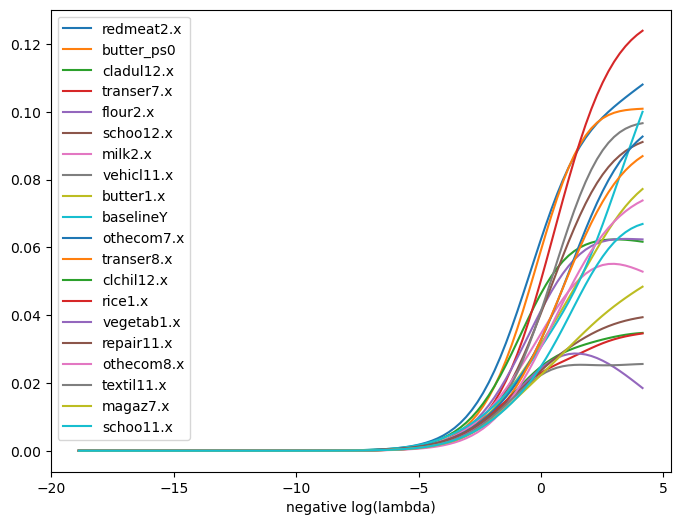

In [11]:
# Ridge: Interpretable Diagnostics Plot
top_vars = ridge_coefs.abs().sort_values(ascending=False).head(20).index
soln_path[top_vars].plot(figsize=(8,6))
ax.set_xlabel('$-\\log(\\lambda)$'); ax.set_ylabel('Standardized coefficients');
ax.set_title('Ridge Coefficient Paths — Top 20 at tuned $\\lambda^*$');


# LASSO

In [12]:
# LASSO: CV with ElasticNetCV
lassoCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=kfold)
pipe_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipe_lasso.fit(X, Y)
tuned_lasso = pipe_lasso.named_steps['lasso']

best_alpha_lasso = tuned_lasso.alpha_
print("LASSO — best lambda (alpha):", best_alpha_lasso)
print("LASSO — min CV MSE:", float(tuned_lasso.mse_path_.mean(1).min()))


LASSO — best lambda (alpha): 0.01580660065737152
LASSO — min CV MSE: 0.10610183851005668


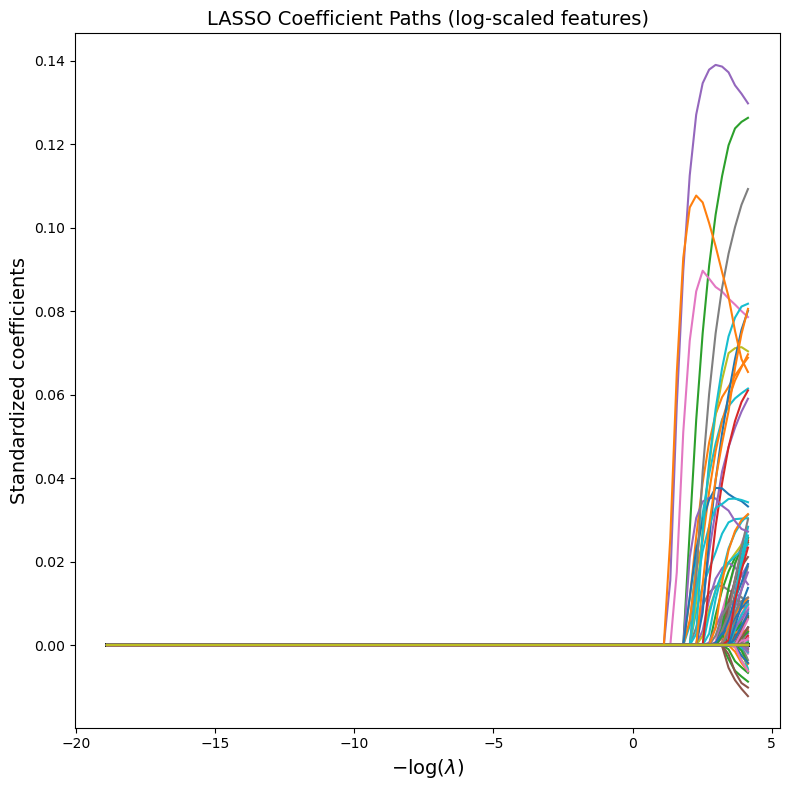

In [13]:
# --- LASSO coefficient path ---
from sklearn.linear_model import ElasticNet

# Reuse standardized Xs from earlier
# (If you restarted your notebook, rerun the standardization cell first)
lasso_path = ElasticNet.path(Xs, Y, l1_ratio=1.0, alphas=lambdas)[1]
lasso_path_df = pd.DataFrame(lasso_path.T, columns=feature_names, index=-np.log(lambdas))
lasso_path_df.index.name = 'negative log(lambda)'

# Plot: LASSO paths show coefficients hitting zero
fig, ax = subplots(figsize=(8,8))
lasso_path_df.plot(ax=ax, legend=False)
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=14)
ax.set_ylabel('Standardized coefficients', fontsize=14)
ax.set_title("LASSO Coefficient Paths (log-scaled features)", fontsize=14);
fig.tight_layout()


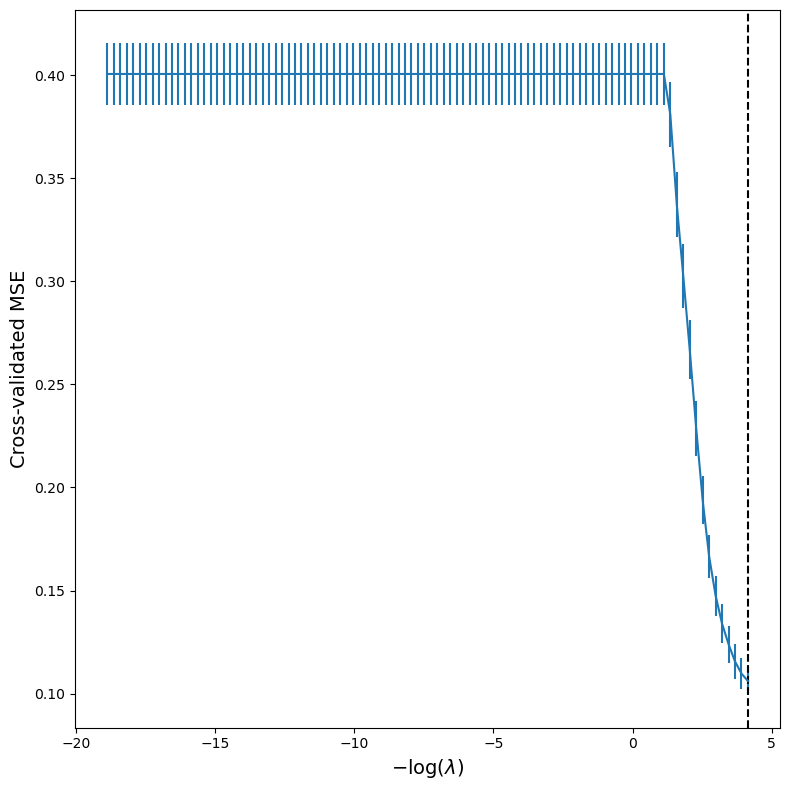

In [14]:
# LASSO: CV MSE Curve
lasso_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1)/np.sqrt(K))
ax.axvline(-np.log(best_alpha_lasso), c='k', ls='--')
ax.set_xlabel('$-\\log(\\lambda)$', fontsize=14)
ax.set_ylabel('Cross-validated MSE', fontsize=14)
lasso_fig.tight_layout()


In [15]:
# LASSO: Coefficients at Tuned Lambda
lasso_coefs = pd.Series(tuned_lasso.coef_, index=feature_names)
nz = (lasso_coefs != 0).sum()
print(f"LASSO — nonzero coefficients: {nz} / {len(lasso_coefs)}")
lasso_coefs.sort_values(key=np.abs, ascending=False).head(30)


LASSO — nonzero coefficients: 103 / 719


redmeat2.x    0.129834
butter_ps0    0.126368
transer7.x    0.109305
transer8.x    0.081826
vehicl11.x    0.080592
schoo12.x     0.080156
cladul12.x    0.078628
schoo11.x     0.070427
othecom7.x    0.069711
butter1.x     0.068888
baselineY     0.065475
milk2.x       0.061496
othecom8.x    0.061062
flour2.x      0.059067
vegetab1.x    0.034259
rice1.x       0.033249
othdair2.x    0.031409
choco3.x      0.031247
othdair1.x    0.030432
recreat7.x    0.030157
fuel8.x       0.028397
bread1.x      0.028318
repair11.x    0.027227
recreat8.x    0.026299
flour1.x      0.025812
feltger7.x    0.025687
clchil12.x    0.025460
butter2.x     0.025005
alcohol1.x    0.024563
magaz7.x      0.024151
dtype: float64

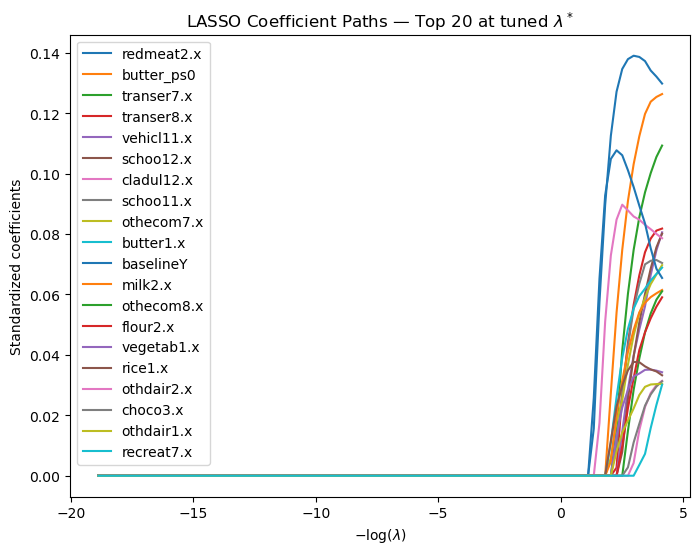

In [16]:
# LASSO: Interpretable Diagnostics Plot (top at tuned λ*)
# Requires:
#   - lasso_coefs: pd.Series(tuned_lasso.coef_, index=feature_names)
#   - lasso_path_df: DataFrame from ElasticNet.path(..., l1_ratio=1.0) with index = -log(lambda)

top_vars = lasso_coefs.abs().sort_values(ascending=False).head(20).index
ax = lasso_path_df[top_vars].plot(figsize=(8,6))
ax.set_xlabel('$-\\log(\\lambda)$'); ax.set_ylabel('Standardized coefficients');
ax.set_title('LASSO Coefficient Paths — Top 20 at tuned $\\lambda^*$');



# LASSO & Ridge Intersections

In [ ]:
# Intersections Between LASSO and Ridge

## Top K-Sets
K = 20
topR = ridge_coefs.abs().sort_values(ascending=False).head(K)
topL = lasso_coefs.abs().sort_values(ascending=False).head(K)

setR, setL = set(topR.index), set(topL.index)
intersect = sorted(setR & setL)

print(f"Top-{K} sizes — Ridge: {len(setR)}, LASSO: {len(setL)}, Intersection: {len(intersect)}")


## Scatter: Ridge vs. LASSO for the intersection
import matplotlib.pyplot as plt

dfI = (pd.DataFrame({
    "ridge": ridge_coefs.abs(),
    "lasso": lasso_coefs.abs()
})
 .loc[intersect]
 .sort_values("lasso", ascending=False))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(dfI["ridge"], dfI["lasso"])
for name, row in dfI.iterrows():
    ax.annotate(name, (row["ridge"], row["lasso"]), fontsize=8, xytext=(2,2), textcoords="offset points")

m = max(dfI.values.max(), 1e-8)
ax.plot([0,m],[0,m], ls="--", c="k", lw=1)  # 45° line
ax.set_xlabel(r"|$\beta$| Ridge at $\lambda^*$"); ax.set_ylabel(r"|$\beta$| LASSO at $\lambda^*$")
ax.set_title(f"Intersection of Top-{K}: Magnitudes")
fig.tight_layout()


## Bars: Intersection Sorted by a Joint Score
score = (dfI["ridge"] * dfI["lasso"])**0.5  # robust to one-sided spikes
plot_df = dfI.assign(score=score).sort_values("score", ascending=True)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(plot_df.index, plot_df["score"])
ax.set_xlabel("Joint importance (√(|β_Ridge| × |β_LASSO|))")
ax.set_title(f"Intersection Top-{K}: Joint score")
fig.tight_layout()


## Table
out = dfI.assign(joint_score=score).sort_values("joint_score", ascending=False)
out.to_csv("topK_intersection_ridge_lasso.csv")
out.head(10)


In [ ]:
# Outer Validation
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)
inner_cv = skm.KFold(n_splits=5, shuffle=True, random_state=2)

# Ridge tuned inside, evaluated outside
ridgeCV_inner = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv)
pipe_ridge_outer = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV_inner)])

ridge_outer = skm.cross_validate(pipe_ridge_outer, X, Y, cv=outer_valid,
                                 scoring='neg_mean_squared_error', return_estimator=False)
print("Outer test MSE (Ridge tuned via inner CV):", float(-ridge_outer['test_score']))

# LASSO tuned inside, evaluated outside
lassoCV_inner = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=inner_cv)
pipe_lasso_outer = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV_inner)])

lasso_outer = skm.cross_validate(pipe_lasso_outer, X, Y, cv=outer_valid,
                                 scoring='neg_mean_squared_error', return_estimator=False)
print("Outer test MSE (LASSO tuned via inner CV):", float(-lasso_outer['test_score']))


In [ ]:
# Post-LASSO ANCOVA



# Tree Methods

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm

from sklearn.tree import DecisionTreeRegressor as DTR, plot_tree
from sklearn.ensemble import RandomForestRegressor as RF, GradientBoostingRegressor as GBR


In [ ]:
# Hook into the cleaned data
assert 'X_proc' in globals() and 'Y_use' in globals(), "Run the cleaning code first."

feature_names = X_proc.columns.tolist()
X = X_proc.values.astype(float)   # trees don’t need scaling
Y = Y_use.values.astype(float)

print("Shapes — X:", X.shape, "Y:", Y.shape)


In [ ]:
# Train Test Split
(X_train, X_test, y_train, y_test) = skm.train_test_split(
    X, Y, test_size=0.30, random_state=0
)


In [ ]:
# Simple Regression Tree + Pruning
reg = DTR(max_depth=3, random_state=0).fit(X_train, y_train)

# Cost-complexity path and CV to pick ccp_alpha
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(
    DTR(random_state=0),
    {'ccp_alpha': ccp_path.ccp_alphas},
    refit=True,
    cv=kfold,
    scoring='neg_mean_squared_error'
).fit(X_train, y_train)

reg_best = grid.best_estimator_
mse_tree = np.mean((y_test - reg_best.predict(X_test))**2)
print("Test MSE — Pruned regression tree:", mse_tree)

# (Optional) visualize
# ax = subplots(figsize=(12,12))[1]; plot_tree(reg_best, feature_names=feature_names, ax=ax);


In [ ]:
# Bagging (RF with max_features=p)
p = X_train.shape[1]
bag = RF(
    n_estimators=500,
    max_features=p,           # p → bagging
    bootstrap=True,
    random_state=0,
    n_jobs=-1
).fit(X_train, y_train)

y_hat_bag = bag.predict(X_test)
mse_bag = np.mean((y_test - y_hat_bag)**2)
print("Test MSE — Bagging (n=500):", mse_bag)

# Variable importance (relative decrease in impurity)
bag_imp = pd.DataFrame({'feature': feature_names, 'importance': bag.feature_importances_}) \
            .sort_values('importance', ascending=False)
bag_imp.head(15)


In [ ]:
# Random Forest
# Common choice: max_features = sqrt(p) (rounded)
mtry = max(1, int(np.sqrt(p)))

rf = RF(
    n_estimators=500,
    max_features=mtry,        # < p → random forest
    bootstrap=True,
    random_state=0,
    n_jobs=-1
).fit(X_train, y_train)

y_hat_rf = rf.predict(X_test)
mse_rf = np.mean((y_test - y_hat_rf)**2)
print(f"Test MSE — Random Forest (mtry={mtry}, n=500):", mse_rf)

rf_imp = pd.DataFrame({'feature': feature_names, 'importance': rf.feature_importances_}) \
           .sort_values('importance', ascending=False)
rf_imp.head(15)


In [ ]:
# Gradient Boosting
# Small learning rate (many trees)
gbr_small = GBR(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=3,
    random_state=0
).fit(X_train, y_train)

y_hat_gbr_small = gbr_small.predict(X_test)
mse_gbr_small = np.mean((y_test - y_hat_gbr_small)**2)
print("Test MSE — GBR (lr=0.001, trees=5000):", mse_gbr_small)

# Larger learning rate (same as doc’s second run)
gbr_big = GBR(
    n_estimators=5000,
    learning_rate=0.2,
    max_depth=3,
    random_state=0
).fit(X_train, y_train)

y_hat_gbr_big = gbr_big.predict(X_test)
mse_gbr_big = np.mean((y_test - y_hat_gbr_big)**2)
print("Test MSE — GBR (lr=0.2, trees=5000):", mse_gbr_big)

# (Optional) staged train/test error curves (same as doc)
# test_error = np.fromiter(
#     (np.mean((y_test - y_)**2) for y_ in gbr_small.staged_predict(X_test)),
#     dtype=float
# )
# fig, ax = subplots(figsize=(8,8))
# ax.plot(np.arange(len(gbr_small.train_score_)), gbr_small.train_score_, label='Training')
# ax.plot(np.arange(len(test_error)), test_error, label='Test')
# ax.legend();


In [ ]:
# Quick Comparison Table
summary = pd.DataFrame({
    'Model': ['Pruned Tree', 'Bagging (p)', f'Random Forest (mtry={mtry})', 'GBR (lr=1e-3)', 'GBR (lr=0.2)'],
    'Test_MSE': [mse_tree, mse_bag, mse_rf, mse_gbr_small, mse_gbr_big]
})
summary


In [ ]:
# Outer Validation for a single method
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)

rf_for_cv = RF(n_estimators=500, max_features=mtry, bootstrap=True, random_state=0, n_jobs=-1)
rf_outer = skm.cross_validate(rf_for_cv, X, Y, cv=outer_valid,
                              scoring='neg_mean_squared_error', return_estimator=False)
print("Outer test MSE — Random Forest:", float(-rf_outer['test_score']))


In [ ]:
# Importance Matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_importance(estimator, feature_names, K=20, title="Feature importance (top-K)"):
    imp = pd.Series(estimator.feature_importances_, index=feature_names)
    top = imp.sort_values(ascending=False).head(K)[::-1]  # reverse for barh order
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(top.index, top.values)
    ax.set_xlabel("Importance")
    ax.set_title(title)
    fig.tight_layout()
    return imp.sort_values(ascending=False)  # also return full, sorted importance

# Bagging Top 20
bag_imp_sorted = plot_top_importance(bag, feature_names, K=20, title="Bagging — Top 20 Importances")

# Random Forest Top 20
rf_imp_sorted = plot_top_importance(rf, feature_names, K=20, title="Random Forest — Top 20 Importances")

# Gradient Boosting Top 20
gbr_imp_sorted = plot_top_importance(gbr_big, feature_names, K=20, title="Gradient Boosting — Top 20 Importances")



In [ ]:
# Single Tree
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);


ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)


best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)


ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);


# Bagging, Random Forest, Gradient Boosting Intersections

In [ ]:
# ===== Tree-Model Intersections: Bagging, RF, Gradient Boosting =====
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 1) Build aligned importance table (fill missing with 0)
imp_df = pd.concat(
    [
        bag_imp_sorted.rename("bag"),
        rf_imp_sorted.rename("rf"),
        gbr_imp_sorted.rename("gbr"),
    ],
    axis=1
).fillna(0.0)

# 2) Normalize importances within each model (sum to 1) for comparability
imp_norm = imp_df.div(imp_df.sum(axis=0), axis=1)

# 3) Intersection sets of top-K features
K = 20
top_bag = set(imp_norm["bag"].nlargest(K).index)
top_rf  = set(imp_norm["rf"].nlargest(K).index)
top_gbr = set(imp_norm["gbr"].nlargest(K).index)

intersection_3 = top_bag & top_rf & top_gbr
intersection_bag_rf  = top_bag & top_rf
intersection_bag_gbr = top_bag & top_gbr
intersection_rf_gbr  = top_rf & top_gbr
union_3 = top_bag | top_rf | top_gbr

print(f"[counts] |bag∩rf∩gbr| = {len(intersection_3)}")
print(f"[counts] |bag∩rf| = {len(intersection_bag_rf)}, |bag∩gbr| = {len(intersection_bag_gbr)}, |rf∩gbr| = {len(intersection_rf_gbr)}")
print(f"[counts] union size (top-{K} across all) = {len(union_3)}")

# 4) Joint importance score (geometric mean across models)
#    If a feature has zero in any model, the geo-mean is 0 (sensible for intersections).
joint_all = (imp_norm["bag"] * imp_norm["rf"] * imp_norm["gbr"]) ** (1/3)
joint_all = joint_all.rename("joint_geom")

# 5) Plot: Top-20 by joint score
topJ = joint_all.sort_values(ascending=False).head(20).iloc[::-1]  # reverse for barh order
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(topJ.index, topJ.values)
ax.set_xlabel("Joint importance (geometric mean of normalized importances)")
ax.set_title(f"Intersection Top-20: Joint score (Bagging × RF × GBR)")
fig.tight_layout()
fig.savefig("trees_jointimportance_bag_rf_gbr_top20.png", dpi=300)

# 6) Pairwise scatter comparisons with 45° line
def pair_scatter(xcol, ycol, title, fname, annotate_n=12):
    x = imp_norm[xcol]
    y = imp_norm[ycol]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x, y, s=16, alpha=0.7)
    lim = (0, max(x.max(), y.max()) * 1.05)
    ax.plot(lim, lim, ls="--", lw=1)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xlabel(f"|importance| normalized — {xcol.upper()}")
    ax.set_ylabel(f"|importance| normalized — {ycol.upper()}")
    ax.set_title(title)
    # annotate top points by average rank to avoid clutter
    avg_rank = (x.rank(ascending=False) + y.rank(ascending=False)) / 2
    top_idx = avg_rank.nsmallest(annotate_n).index
    for f in top_idx:
        ax.annotate(f, (x.loc[f], y.loc[f]), xytext=(3, 3), textcoords="offset points", fontsize=8)
    fig.tight_layout()
    fig.savefig(fname, dpi=300)

pair_scatter("bag", "rf",  "Intersection of Bagging and RF (normalized importances)",
             "trees_intersection_bag_rf.png")
pair_scatter("bag", "gbr", "Intersection of Bagging and GBR (normalized importances)",
             "trees_intersection_bag_gbr.png")
pair_scatter("rf",  "gbr", "Intersection of RF and GBR (normalized importances)",
             "trees_intersection_rf_gbr.png")

# 7) Optional: report a small table of top-K intersection with per-model importances and joint
report = pd.concat([imp_norm.loc[topJ.index], joint_all.loc[topJ.index]], axis=1) \
           .sort_values("joint_geom", ascending=False)
print(report.round(4).head(20))
report.to_csv("trees_intersection_report_top20.csv")


# DAGs

In [3]:
# === Week 6 DAGs when adoption D is unobserved ===
# Produces two families of figures in week6_outputs/: ITT_* (reduced-form) and IV_* (conceptual, with latent D)
import os
import matplotlib.pyplot as plt
import networkx as nx

OUT = "week6_outputs"
os.makedirs(OUT, exist_ok=True)

# ------------------------
# Helpers (shared)
# ------------------------
def layered_layout(tiers, xgap=1.8, ygap=1.2):
    pos = {}
    for y, (tier, nodes) in enumerate(sorted(tiers.items())):
        n = len(nodes)
        xs = [xgap * (i - (n-1)/2) for i in range(n)]
        for x, node in zip(xs, nodes):
            pos[node] = (x, -ygap * y)
    return pos

def draw_dag(nodes, solid_edges, excluded_edges, tiers, title, fname,
             latent_nodes=None):
    latent_nodes = set(latent_nodes or [])
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(solid_edges + excluded_edges)

    pos = layered_layout(tiers)
    fig, ax = plt.subplots(figsize=(10, 6))
    NODE_SIZE = 1600

    # colors by tier (consistent palette)
    palette = {
        0: "#6baed6", 1: "#9ecae1", 2: "#c7e9c0",
        3: "#a1d99b", 4: "#fdd0a2", 5: "#fdae6b"
    }
    def tier_of(n):
        for t, ns in tiers.items():
            if n in ns: return t
        return 3

    # nodes
    node_color = []
    node_edge  = []
    for n in G.nodes():
        if n in latent_nodes:
            node_color.append("#eeeeee")       # grey fill for latent
            node_edge.append((0.0, 0.0, 0.0, 0.6))  # darker border
        else:
            node_color.append(palette[tier_of(n)])
            node_edge.append("black")

    nx.draw_networkx_nodes(G, pos, node_size=NODE_SIZE,
                           node_color=node_color, edgecolors=node_edge,
                           linewidths=0.8, ax=ax)

    # edges
    edge_kws = dict(arrows=True, arrowstyle="-|>", arrowsize=24, width=1.8,
                    connectionstyle="arc3,rad=0.0", node_size=NODE_SIZE, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=solid_edges, **edge_kws)
    nx.draw_networkx_edges(G, pos, edgelist=excluded_edges,
                           style="dashed", edge_color="#888", alpha=0.9, **edge_kws)

    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    # legend
    import matplotlib.patches as mpatches
    patches = []
    for t in sorted(tiers):
        patches.append(mpatches.Patch(color=palette[t],
                     label=f"Tier {t}: {', '.join(s.split(' ')[0] for s in tiers[t])}"))
    patches.append(mpatches.Patch(facecolor="#eeeeee", edgecolor="black",
                                  label="Latent (unobserved)"))
    patches.append(mpatches.FancyBboxPatch((0,0), 0, 0, boxstyle="square,pad=0",
                 ec="black", fc="white", label="Assumed causal link"))
    patches.append(mpatches.FancyBboxPatch((0,0), 0, 0, boxstyle="square,pad=0",
                 ec="#888", fc="white", linestyle="--", label="Excluded (assumption)"))
    ax.legend(handles=patches, loc="upper left", bbox_to_anchor=(1.02, 1.0),
              fontsize=8, frameon=False)

    ax.set_title(title, fontsize=12)
    ax.set_axis_off()
    plt.tight_layout()
    path = os.path.join(OUT, fname)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", path)

# ------------------------
# A) ITT (reduced-form) DAGs — no D node
# ------------------------
Xa = "X_assets (Assets/Finance)"
Xi = "X_income (Income/Transfers)"
Xd = "X_demo (Demographics)"
Xg = "X_geo (Geography)"
Z  = "Z (Offer)"
Y0 = "Y0 (Baseline Y)"
Y1 = "Y1 (Outcome)"
U  = "U (Village unobs.)"

TIERS_ITT = {
    0: [Z, U],
    1: [Xg, Xd],
    2: [Xi, Xa],
    3: [Y0],
    4: [],            # (no adoption layer)
    5: [Y1],
}

BASE_ITT = [
    (Z, Y1),              # reduced-form offer effect
    (Y0, Y1),             # persistence
    # baseline formation & hierarchy
    (Xg, Xi), (Xd, Xi), (Xi, Xa),
    (Xg, Y0), (Xd, Y0), (Xi, Y0), (Xa, Y0),
    # direct determinants of Y1
    (Xd, Y1), (Xi, Y1), (Xa, Y1),
    # village unobservables
    (U, Y0), (U, Y1),
]

def itt_H0_rich():
    nodes = sum(TIERS_ITT.values(), [])
    return nodes, list(BASE_ITT), [], TIERS_ITT, \
        "ITT-H0: Rich reduced-form (Z→Y₁; no D observed)", "ITT_H0_rich.png"

def itt_H1_exclusion():
    # emphasize randomization: exclude Z→Y0 and U→Z
    nodes = sum(TIERS_ITT.values(), [])
    solid = list(BASE_ITT)
    excluded = [(Z, Y0), (U, Z)]
    return nodes, solid, excluded, TIERS_ITT, \
        "ITT-H1: Randomization exclusions (Z ⟂ Y₀; U ⟂ Z)", "ITT_H1_exclusion.png"

def itt_H2_geo_upstream():
    nodes = sum(TIERS_ITT.values(), [])
    solid = [e for e in BASE_ITT if not (e[0] == Xg and e[1] in {Y0, Y1})] + [(Xg, Xi)]
    excluded = [(Xg, Y0), (Xg, Y1)]
    return nodes, solid, excluded, TIERS_ITT, \
        "ITT-H2: Geography upstream (Xg→Xi only)", "ITT_H2_geo_upstream.png"

# ------------------------
# B) Conceptual IV DAG — keep D as latent for exposition only
# ------------------------
D = "D (Adoption)"   # latent in our data

TIERS_IV = {
    0: [Z, U],
    1: [Xg, Xd],
    2: [Xi, Xa],
    3: [Y0],
    4: [D],           # unobserved
    5: [Y1],
}

BASE_IV = [
    (Z, D), (D, Y1), (Y0, Y1),
    (Xg, Xi), (Xd, Xi), (Xi, Xa),
    (Xg, Y0), (Xd, Y0), (Xi, Y0), (Xa, Y0),
    (Xd, Y1), (Xi, Y1), (Xa, Y1),
    (Xd, D), (Xi, D), (Xa, D),
    (U, D), (U, Y0), (U, Y1),
]

def iv_conceptual_exclusion():
    nodes = sum(TIERS_IV.values(), [])
    solid = list(BASE_IV)           # Z affects Y1 only via D
    excluded = [(Z, Y1), (Z, Y0)]
    return nodes, solid, excluded, TIERS_IV, \
        "IV (conceptual): Z→D→Y₁, D latent; exclude Z→Y", "IV_conceptual.png"

# ------------------------
# Render all
# ------------------------
for maker in [itt_H0_rich, itt_H1_exclusion, itt_H2_geo_upstream]:
    n, s, ex, tiers, title, fn = maker()
    draw_dag(n, s, ex, tiers, title, fn)

# Conceptual IV picture with D marked latent
n, s, ex, tiers, title, fn = iv_conceptual_exclusion()
draw_dag(n, s, ex, tiers, title, fn, latent_nodes={D})


Saved: week6_outputs/ITT_H0_rich.png


/tmp/ipykernel_1013/2168949535.py:84: UserWarning: Glyph 10178 (\N{PERPENDICULAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1013/2168949535.py:86: UserWarning: Glyph 10178 (\N{PERPENDICULAR}) missing from font(s) DejaVu Sans.
  plt.savefig(path, dpi=300, bbox_inches="tight")


Saved: week6_outputs/ITT_H1_exclusion.png
Saved: week6_outputs/ITT_H2_geo_upstream.png
Saved: week6_outputs/IV_conceptual.png


# Backdoor (ANCOVA) matching my DAG with baseline controls


In [ ]:
# Week 6: use existing cleaned data
%pip install -q dowhy
%pip install -q econml

import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

# Sanity: make sure these exist from your cleaning cell
assert 'Y_use' in globals(), "Run your cleaning cell first (it defines Y_use)."
assert 'X_scaled' in globals(), "Run your cleaning cell first (it defines X_scaled)."
assert 'Y_col' in globals(), "Run your cleaning cell first (it defines Y_col)."

# Choose treatment for Week 6 (pooled ITT by default)
TREAT_NAME = "treat_any"   # or "treat_indiv", "treat_group"
CONF1_NAME = "baselineY"   # keep it simple: ANCOVA with baseline outcome

for need in [TREAT_NAME, CONF1_NAME]:
    assert need in X_scaled.columns, f"Missing column in X_scaled: {need}"

print(f"[wk6] Outcome={Y_col}, Treatment={TREAT_NAME}, Confounder={CONF1_NAME}")
print("[wk6] X_scaled shape:", X_scaled.shape)


In [ ]:
# Build the compact dataframe DoWhy will use
df_A = pd.DataFrame({
    "X":  X_scaled[TREAT_NAME].astype(float).values,
    "Y":  pd.to_numeric(Y_use, errors="coerce").astype(float).values,
    "C1": X_scaled[CONF1_NAME].astype(float).values
})
# Optionally add one extra baseline control as C2 (keep it minimal)
# ex_name = "urban0"  # <- if it exists in X_scaled, uncomment next 2 lines
# if ex_name in X_scaled.columns: df_A["C2"] = X_scaled[ex_name].astype(float).values

# Minimal back-door graph: C1 → {X,Y}, X → Y
gml_backdoor = f"""
graph [
  directed 1
  node [id "X"  label "X"]
  node [id "Y"  label "Y"]
  node [id "C1" label "C1"]
  edge [source "C1" target "X"]
  edge [source "C1" target "Y"]
  edge [source "X"  target "Y"]
  {"node [id \"C2\" label \"C2\"] edge [source \"C2\" target \"X\"] edge [source \"C2\" target \"Y\"]" if "C2" in df_A.columns else ""}
]
"""

model_A = CausalModel(
    data=df_A,
    treatment="X",
    outcome="Y",
    graph=gml_backdoor
)


In [ ]:
# Identify
estimand_A = model_A.identify_effect()
print(estimand_A)


In [ ]:
# Estimate
estimate_A = model_A.estimate_effect(
    identified_estimand=estimand_A,
    method_name="backdoor.linear_regression"
)
print("Back-door (ANCOVA) estimate:", estimate_A.value)


In [ ]:
# Refute
ref_subset_A = model_A.refute_estimate(
    estimand=estimand_A,
    estimate=estimate_A,
    method_name="data_subset_refuter",
    subset_fraction=0.4
)
print(ref_subset_A)

ref_placebo_A = model_A.refute_estimate(
    estimand=estimand_A,
    estimate=estimate_A,
    method_name="placebo_treatment_refuter"
)
print(ref_placebo_A)
